In [3]:
import pandas as pd
import numpy as np

dataset = pd.read_csv('air_quality.csv', encoding = 'latin1')

print('\nFirst 5 rows:\n', dataset.head())
print('\nColumns:\n', dataset.columns)
print('\nShape:\n', dataset.shape)


First 5 rows:
   stn_code       sampling_date           state   location agency  \
0    150.0  February - M021990  Andhra Pradesh  Hyderabad    NaN   
1    151.0  February - M021990  Andhra Pradesh  Hyderabad    NaN   
2    152.0  February - M021990  Andhra Pradesh  Hyderabad    NaN   
3    150.0     March - M031990  Andhra Pradesh  Hyderabad    NaN   
4    151.0     March - M031990  Andhra Pradesh  Hyderabad    NaN   

                                 type  so2   no2  rspm  spm  \
0  Residential, Rural and other Areas  4.8  17.4   NaN  NaN   
1                     Industrial Area  3.1   7.0   NaN  NaN   
2  Residential, Rural and other Areas  6.2  28.5   NaN  NaN   
3  Residential, Rural and other Areas  6.3  14.7   NaN  NaN   
4                     Industrial Area  4.7   7.5   NaN  NaN   

  location_monitoring_station  pm2_5        date  
0                         NaN    NaN  01-02-1990  
1                         NaN    NaN  01-02-1990  
2                         NaN    NaN  01-02

/tmp/ipython-input-4131937415.py:4: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv('air_quality.csv', encoding = 'latin1')


In [5]:
#Step 1
x = dataset['no2']
x

# transformation function
def transform(x, r):
    a_r = 0.5*(r%7)
    b_r = 0.5*(r%5+1)
    z = x+a_r*np.sin(b_r*x)

    return z

roll_number = 102317253

z = transform(x,roll_number)

print(z)

0         17.039833
1          8.485911
2         29.154247
3         13.346168
4          8.475432
            ...    
435737    49.240452
435738    44.830801
435739          NaN
435740          NaN
435741          NaN
Name: no2, Length: 435742, dtype: float64


In [6]:
# Step 2
from keras.models import Sequential
from keras.layers import Dense
from numpy.random import randn
from numpy.random import randint
from numpy import ones, zeros

z_clean = z.dropna().values
z_clean = z_clean.reshape(len(z_clean), 1)

def generate_real_samples(n):
    idx = randint(0, z_clean.shape[0], n)
    X = z_clean[idx]
    y = ones((n, 1))
    return X, y

def generate_fake_samples(generator, n):
    error = randn(n, 1)
    X = generator.predict(error, verbose=0)
    y = zeros((n, 1))
    return X, y

def define_discriminator():
    model = Sequential()
    model.add(Dense(16, activation='relu', input_dim=1))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

def define_generator():
    model = Sequential()
    model.add(Dense(16, activation='relu', input_dim=1))
    model.add(Dense(1))
    return model

def define_gan(generator, discriminator):
    discriminator.trainable = False
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

discriminator = define_discriminator()
generator = define_generator()
gan_model = define_gan(generator, discriminator)

epochs = 1000
batch = 64
half_batch = batch // 2

for i in range(epochs):
    X_real, y_real = generate_real_samples(half_batch)
    discriminator.train_on_batch(X_real, y_real)

    X_fake, y_fake = generate_fake_samples(generator, half_batch)
    discriminator.train_on_batch(X_fake, y_fake)

    error = randn(batch, 1)
    y_gan = ones((batch, 1))
    gan_model.train_on_batch(error, y_gan)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py:83: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


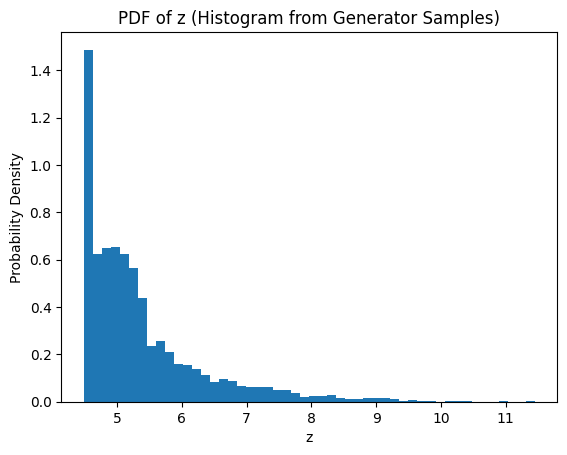

In [7]:
# Step 3
from numpy.random import randn

n_samples = 5000
error = randn(n_samples, 1)

z_f = generator.predict(error, verbose=0)

import matplotlib.pyplot as plt

plt.hist(z_f, bins=50, density=True)
plt.xlabel("z")
plt.ylabel("Probability Density")
plt.title("PDF of z (Histogram from Generator Samples)")
plt.show()